### multiround federated CNN 3x3 no autoencoder

In [5]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os

from sklearn.metrics import mean_squared_error
from tensorflow.keras import models, layers

os.makedirs("models/rounds", exist_ok=True)
os.makedirs("metrics", exist_ok=True)


In [7]:
studies_all = ["SDY569", "SDY797", "SDY1737"]
studies_excl = ["SDY569", "SDY1737"]

n_rounds = 50
epochs_per_round = 1  # for local training
batch_size = 8

# Initialize global models
def init_model():
    model = models.Sequential([
        layers.Input(shape=(3, 3, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

federated_model_all = init_model()
federated_model_excl = init_model()


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# === Standard Features Layout ===
standard_features = [
    "MIAA", "GAD65", "IA2IC", "ICA", "ZNT8",  # autoantibodies
    "8-12", "13-17", ">18", "Sex"            # age + sex indicators
]

studies = ["SDY569", "SDY797", "SDY1737"]

split_data = {}

for study in studies:
    print(f"Loading split data for {study}")

    # Load train/test CSVs
    df_train = pd.read_csv(f"data/cleaned/{study}_train.csv")
    df_test  = pd.read_csv(f"data/cleaned/{study}_test.csv")

    # Ensure no NaNs
    df_train = df_train.fillna(0.0)
    df_test  = df_test.fillna(0.0)

    # Log-transform the AUC
    df_train["log_auc"] = np.log(df_train["C_Peptide_AUC_4Hrs"])
    df_test["log_auc"] = np.log(df_test["C_Peptide_AUC_4Hrs"])

    # Extract features and target
    X_train = df_train[standard_features].values
    X_test  = df_test[standard_features].values
    y_train = df_train["log_auc"].values
    y_test  = df_test["log_auc"].values

    # Normalize
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Reshape for CNN (3x3x1)
    X_train_cnn = X_train_scaled.reshape(-1, 3, 3, 1)
    X_test_cnn  = X_test_scaled.reshape(-1, 3, 3, 1)

    # Store for use
    split_data[study] = {
        "X_train": X_train_cnn,
        "X_test": X_test_cnn,
        "y_train": y_train,
        "y_test": y_test
    }


Loading split data for SDY569
Loading split data for SDY797
Loading split data for SDY1737


In [11]:
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
import os
import numpy as np

# === Model Definition ===
def init_model():
    model = models.Sequential([
        layers.Input(shape=(3, 3, 1)),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# === Rounds Configuration ===
rounds = 100
epochs_per_round = 1
batch_size = 8

# Storage
mse_tracker_all = {study: [] for study in studies}
mse_tracker_excl = {study: [] for study in studies if study != "SDY797"}

# Init models
federated_model_all = init_model()
federated_model_excl = init_model()

# Ensure output directories
os.makedirs("models/federated_rounds", exist_ok=True)
os.makedirs("figures/federated_rounds", exist_ok=True)

# === Federated Loop ===
for r in range(1, rounds + 1):
    print(f"\n=== Federated Round {r} ===")

    # --- With SDY797 ---
    local_weights_all = []
    for study in studies:
        model = init_model()
        model.set_weights(federated_model_all.get_weights())
        model.fit(split_data[study]["X_train"], split_data[study]["y_train"],
                  epochs=epochs_per_round, batch_size=batch_size, verbose=0)
        local_weights_all.append(model.get_weights())

    # Average weights
    new_weights_all = []
    for layer_idx in range(len(local_weights_all[0])):
        layer_stack = np.stack([w[layer_idx] for w in local_weights_all])
        new_weights_all.append(np.mean(layer_stack, axis=0))
    federated_model_all.set_weights(new_weights_all)

    # Save
    federated_model_all.save(f"models/federated_rounds/federated_all_round{r}.keras")

    # Evaluate every 10 rounds
    if r % 10 == 0:
        for study in studies:
            X_test = split_data[study]["X_test"]
            y_test = split_data[study]["y_test"]
            y_pred = federated_model_all.predict(X_test).flatten()
            mse = mean_squared_error(y_test, y_pred)
            mse_tracker_all[study].append(mse)
            print(f"[All] Round {r} — {study} MSE: {mse:.4f}")

    # --- Excluding SDY797 ---
    local_weights_excl = []
    for study in studies:
        if study == "SDY797":
            continue
        model = init_model()
        model.set_weights(federated_model_excl.get_weights())
        model.fit(split_data[study]["X_train"], split_data[study]["y_train"],
                  epochs=epochs_per_round, batch_size=batch_size, verbose=0)
        local_weights_excl.append(model.get_weights())

    new_weights_excl = []
    for layer_idx in range(len(local_weights_excl[0])):
        layer_stack = np.stack([w[layer_idx] for w in local_weights_excl])
        new_weights_excl.append(np.mean(layer_stack, axis=0))
    federated_model_excl.set_weights(new_weights_excl)

    # Save
    federated_model_excl.save(f"models/federated_rounds/federated_excl_SDY797_round{r}.keras")

    if r % 10 == 0:
        for study in studies:
            if study == "SDY797":
                continue
            X_test = split_data[study]["X_test"]
            y_test = split_data[study]["y_test"]
            y_pred = federated_model_excl.predict(X_test).flatten()
            mse = mean_squared_error(y_test, y_pred)
            mse_tracker_excl[study].append(mse)
            print(f"[Excl] Round {r} — {study} MSE: {mse:.4f}")



=== Federated Round 1 ===

=== Federated Round 2 ===

=== Federated Round 3 ===

=== Federated Round 4 ===

=== Federated Round 5 ===

=== Federated Round 6 ===

=== Federated Round 7 ===

=== Federated Round 8 ===

=== Federated Round 9 ===

=== Federated Round 10 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[All] Round 10 — SDY569 MSE: 0.7450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[All] Round 10 — SDY797 MSE: 0.2467
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[All] Round 10 — SDY1737 MSE: 0.7581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[Excl] Round 10 — SDY569 MSE: 0.7681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[Excl] Round 10 — SDY1737 MSE: 0.6905

=== Federated Round 11 ===

=== Federated Round 12 ===

=== Federated Round 13 ===

=== Federated Round 14 ===

=== Federated Round 15 ===

=== Federated Round 16 ===

=== Federated Round 17 ===

=== Federated Round 18 ===

=== Federated Round 19 ===

=== Federated Round 20 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[All] Round 20 — SDY569 MSE: 0.6774
1/1

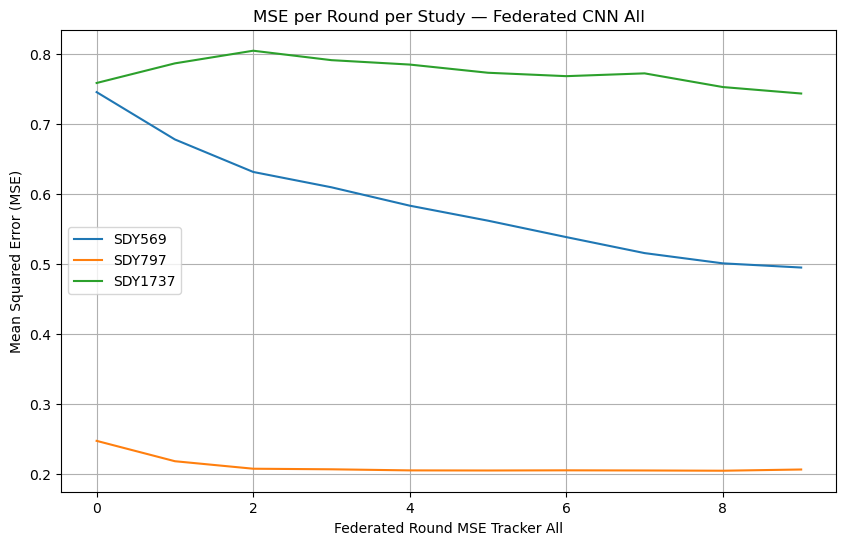

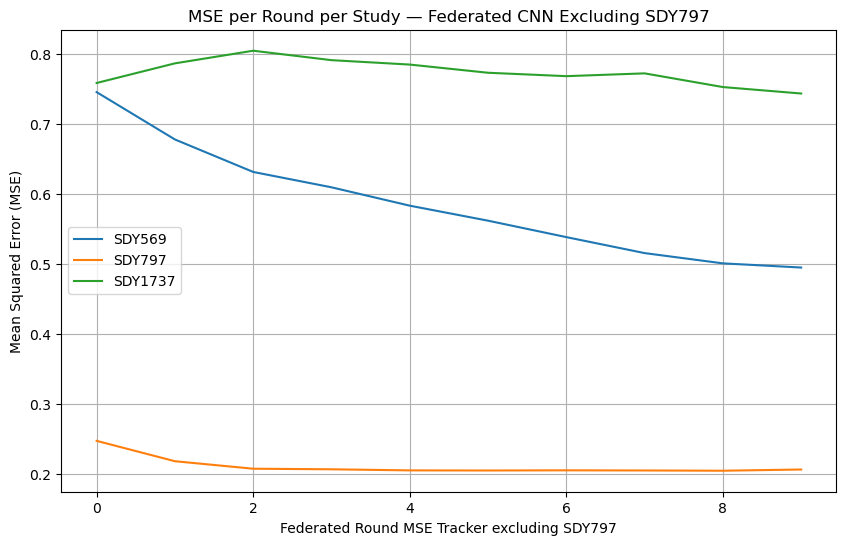

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for study in studies:
    plt.plot(mse_tracker_all[study], label=f"{study}")

plt.xlabel("Federated Round MSE Tracker All")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE per Round per Study — Federated CNN All")
plt.legend()
plt.grid(True)

# Save both versions
plt.savefig("figures/federated_mse_tracker_all_per_round.pdf")
plt.savefig("figures/federated_mse_tracker_all_per_round.png")
plt.show()

# excluding SDY797
plt.figure(figsize=(10, 6))
for study in studies:
    plt.plot(mse_tracker_all[study], label=f"{study}")

plt.xlabel("Federated Round MSE Tracker excluding SDY797")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE per Round per Study — Federated CNN Excluding SDY797")
plt.legend()
plt.grid(True)

# Save both versions
plt.savefig("figures/federated_mse_tracker_excl_sdy797_per_round.pdf")
plt.savefig("figures/federated_mse_tracker_excl_sdy797_per_round.png")
plt.show()